In [1]:
### Import libraries

import igraph as ig
import numpy as np
import os
from collections import Counter, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_opti_two import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [2]:
### Select dataset
DATASET = "am" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Auxiliar functions and variables

In [3]:
# Auxiliar functions
def plot_pie_subplots(proyecciones, backbonings, significancias, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    categories = [
        (proyecciones, "Projections types"),
        (backbonings, "Backboning methods"),
        (OrderedDict(sorted(significancias.items(), key=lambda x: float(x[0]))), "Significance value")
    ]
    color_counter = 0
    for ax, (data, subtitle) in zip(axes, categories):
        labels = list(data.keys())
        sizes = list(data.values())

        if color_counter == 0:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_PR)
        elif color_counter == 1:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_BB)
        else:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_SV)
        color_counter += 1
        ax.set_title(subtitle)
        ax.axis('equal')

    fig.suptitle(f"Distribution of network instance characteristics - {title}", fontsize=14)
    plt.tight_layout()
    plt.savefig(title + "-pastel.png")
    plt.show()

# Función principal
def analizar_frente(front, nombre="Frente"):
    proyecciones = Counter()
    backbonings = Counter()
    significancias = Counter()

    for sol in front:
        if isinstance(sol, dict):
            fname = sol["filename"]
        else:
            fname = sol

        parts = fname.split("_")
        if len(parts) == 3:
            proj, back, alpha = parts

            proj_label = nombre_proyecciones.get(proj, proj)
            back_label = nombre_backbonings.get(back, back)

            proyecciones[proj_label] += 1
            backbonings[back_label] += 1

            if alpha.startswith('a'):
                alpha_val = alpha[1:]
                if len(alpha_val) == 1:
                    alpha_val = f"0.{alpha_val}0"
                elif len(alpha_val) == 2:
                    alpha_val = f"0.{alpha_val}"
                else:
                    alpha_val = f"0.{alpha_val[:2]}"
                significancias[alpha_val] += 1

    print(f"\nResumen para {nombre}")
    print("Proyecciones:", dict(proyecciones))
    print("Backbonings:", dict(backbonings))
    print("Significancias:", dict(significancias))

    # Mostrar los subplots
    plot_pie_subplots(proyecciones, backbonings, significancias, nombre)

### Mapa de figuras, colores, y líneas.

projection_styles = {
    "simple": "tab:blue",
    "jaccard": "tab:orange",
    "neighs": "tab:green",
    "hyper": "tab:red",
    "resall": "tab:purple",
    "vector": "tab:brown"
}


backboning_styles = {
    "DF": "-",    # línea continua
    "NC": "--"    # línea punteada
}

alpha_styles = {
    "a05": "o",   # círculo
    "a1": "s",   # cuadrado
    "a15": "*",   # rombo
    "a2": "^"    # triángulo
}

projection_labels = {
    "simple": "Simple",
    "jaccard": "Jaccard",
    "vector": "Vectorized",
    "neighs": "Neighborhood",
    "hyper": "Hyperbolic",
    "resall": "Resource Allocation"
}

backboning_labels = {
    "DF": "Disparity Filter",
    "NC": "Noise Corrected"
}

alpha_labels = {
    "a05": "0.05",
    "a1": "0.10",
    "a15": "0.15",
    "a2": "0.20"
}

backboning_styles2 = { 'DF': "full", 'NC': "none"}

### Load Dataset

In [4]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH UN-T 511463 1470404 -- 
+ attr: id (v), name (v), type (v)

|U|= 383640  	|R|= 127823  	|U|+|R|= 511463 = 511463

The graph IS bipartite


In [5]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.241,
 'x9': 7.113887200410482,
 'x11': 1.8623650345000595,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.241,
 'x9': 7.113887200410482,
 'x11': 1.8623650345000595,
 'x15': 1.1241883410574385e-05,
 'x16': 3.832770305494735}

In [6]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
#a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
a = pd.DataFrame(to_df, columns=['f1', 'f2'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 20


In [7]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

#analizar_frente(counter_sols, DATASET.upper()+" Top")


Frente 1 (4 soluciones):
imple_NC_a15
yper_NC_a1
yper_NC_a05
yper_NC_a2

Frente 2 (3 soluciones):
imple_NC_a2
yper_NC_a15
eighs_NC_a2

Frente 3 (5 soluciones):
imple_NC_a05
eighs_NC_a15
eighs_NC_a05
imple_NC_a1
eighs_NC_a1

Frente 4 (4 soluciones):
accard_NC_a15
esall_NC_a05
esall_NC_a15
accard_NC_a2

Frente 5 (2 soluciones):
accard_NC_a1
accard_NC_a05

Frente 6 (1 soluciones):
esall_NC_a2

Frente 7 (1 soluciones):
esall_NC_a1


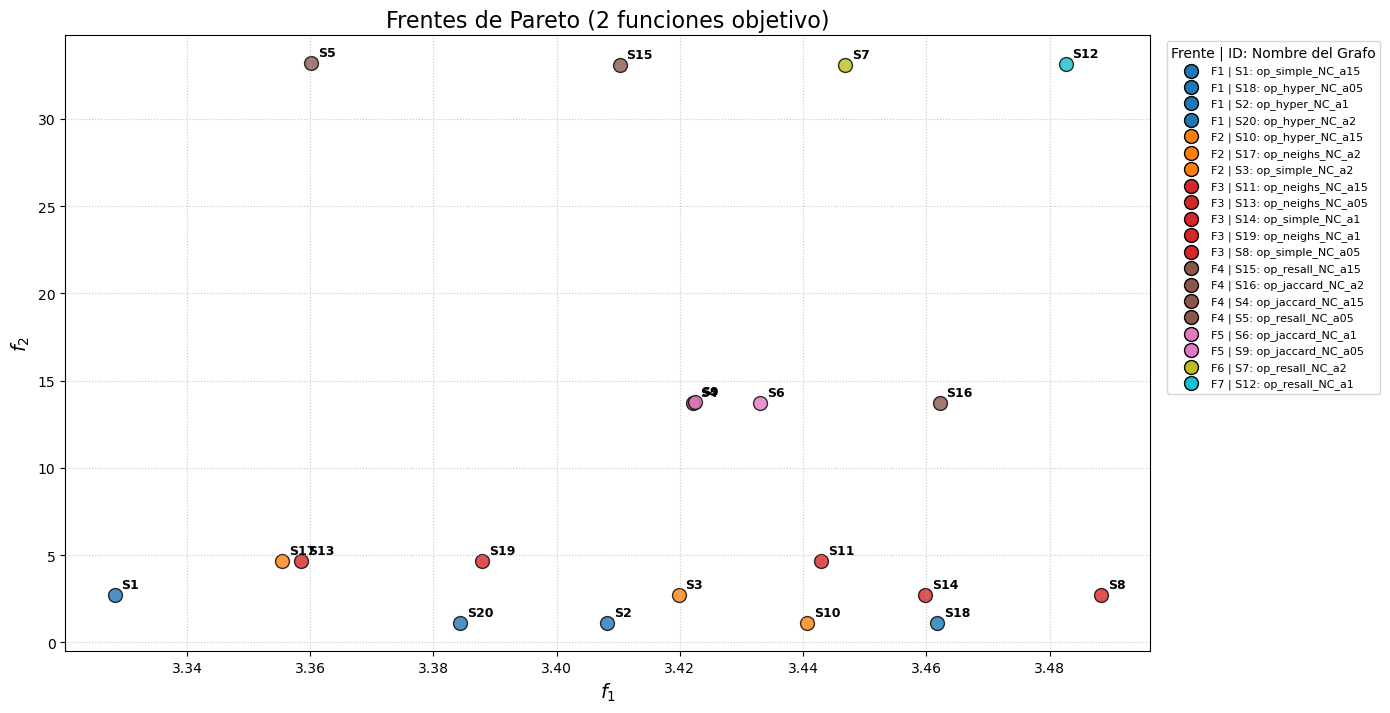

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'name'.
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y ASIGNACIÓN DE RANKS (Reutilizamos el código robusto) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        rank_map[sol["filename"]] = rank

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 

plot_DF = final_DF[final_DF['rank'] > 0].copy()
plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'][4:]}", 
    axis=1
)

# --- 2. GENERAR LA GRÁFICA CON MATPLOTLIB (CORRECCIÓN DE COLOR) ---

plt.figure(figsize=(14, 8)) 

# Obtener los frentes únicos y ordenarlos
unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)

# Usamos un mapa de color más distintivo si el número de frentes es pequeño
if num_unique_ranks <= 10:
    cmap = cm.get_cmap('tab10', num_unique_ranks)
else:
    cmap = cm.get_cmap('tab20', num_unique_ranks)
    #cmap = cm.get_cmap('tab10', num_unique_ranks)

# Diccionario para almacenar handles y etiquetas de la leyenda (para evitar duplicados)
legend_data = {}

# 3a. Graficar los puntos por FRENTE (Esto garantiza el mismo color por frente)
for rank_int in unique_ranks:
    
    # 1. Filtramos el subconjunto para el frente actual
    subset = plot_DF[plot_DF['rank'] == rank_int]
    
    # 2. Obtenemos el color
    color_index = rank_int - 1
    color = cmap(color_index)
    
    # 3. Graficar: Todos los puntos de este subset tendrán el mismo color
    plt.scatter(
        subset['f1'],
        subset['f2'],
        s=100,             
        alpha=0.8,
        edgecolors='black',
        color=color # Asignación de color directo
    )
    
    # Almacenamos handles y etiquetas para la leyenda detallada
    for index, row in subset.iterrows():
        legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}

# 3b. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    plt.annotate(
        row['ID'],  
        (row['f1'], row['f2']),
        textcoords="offset points", 
        xytext=(5, 5),
        ha='left', 
        fontsize=9,
        weight='bold' 
    )

# 3c. Crear la Leyenda detallada (Objetos Proxy)
legend_handles = []
# Ordenamos los IDs por rank para una leyenda lógica
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    
    proxy = plt.scatter([], [], 
                        c=[data['color']], # c acepta lista o tupla para el color
                        label=data['label'], 
                        s=100, edgecolors='black')
    legend_handles.append(proxy)


# 3d. Finalizar el Gráfico
plt.title('Frentes de Pareto (2 funciones objetivo)', fontsize=16)
plt.xlabel('$f_1$', fontsize=14)
plt.ylabel('$f_2$', fontsize=14)

# Mover el recuadro del legend más a la derecha (loc='upper left', bbox_to_anchor=(1.01, 1))
plt.legend(handles=legend_handles, 
           title="Frente | ID: Nombre del Grafo", 
           loc='upper left', 
           bbox_to_anchor=(1.01, 1), 
           fontsize=8)

plt.grid(True, linestyle=':', alpha=0.7)

plt.show()

Matriz de correlación:
          f1        f2
f1  1.000000 -0.180086
f2 -0.180086  1.000000


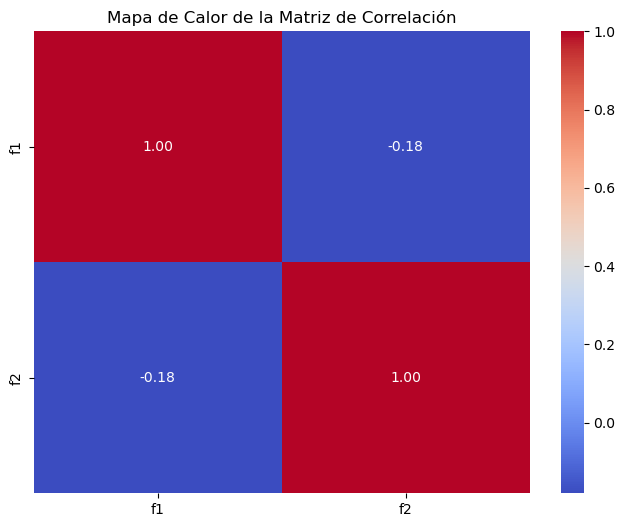

In [9]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-2]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [10]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.242,
 'x9': 7.234182993236018,
 'x11': 5.066327861107771,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.242,
 'x9': 7.234182993236018,
 'x11': 5.066327861107771,
 'x15': 1.1241883410574385e-05,
 'x16': 11.503438348341065}

In [11]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 26


In [12]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)



Frente 1 (2 soluciones):
accard_NC_a05
imple_DF_a15

Frente 2 (4 soluciones):
accard_NC_a2
imple_DF_a2
accard_NC_a1
accard_NC_a15

Frente 3 (10 soluciones):
eighs_NC_a05
eighs_NC_a2
eighs_NC_a15
esall_DF_a1
eighs_NC_a1
imple_NC_a05
esall_DF_a2
esall_DF_a15
esall_DF_a05
imple_NC_a2

Frente 4 (2 soluciones):
yper_NC_a05
imple_NC_a1

Frente 5 (6 soluciones):
yper_NC_a15
imple_NC_a15
esall_NC_a1
yper_NC_a2
esall_NC_a05
esall_NC_a15

Frente 6 (2 soluciones):
esall_NC_a2
yper_NC_a1


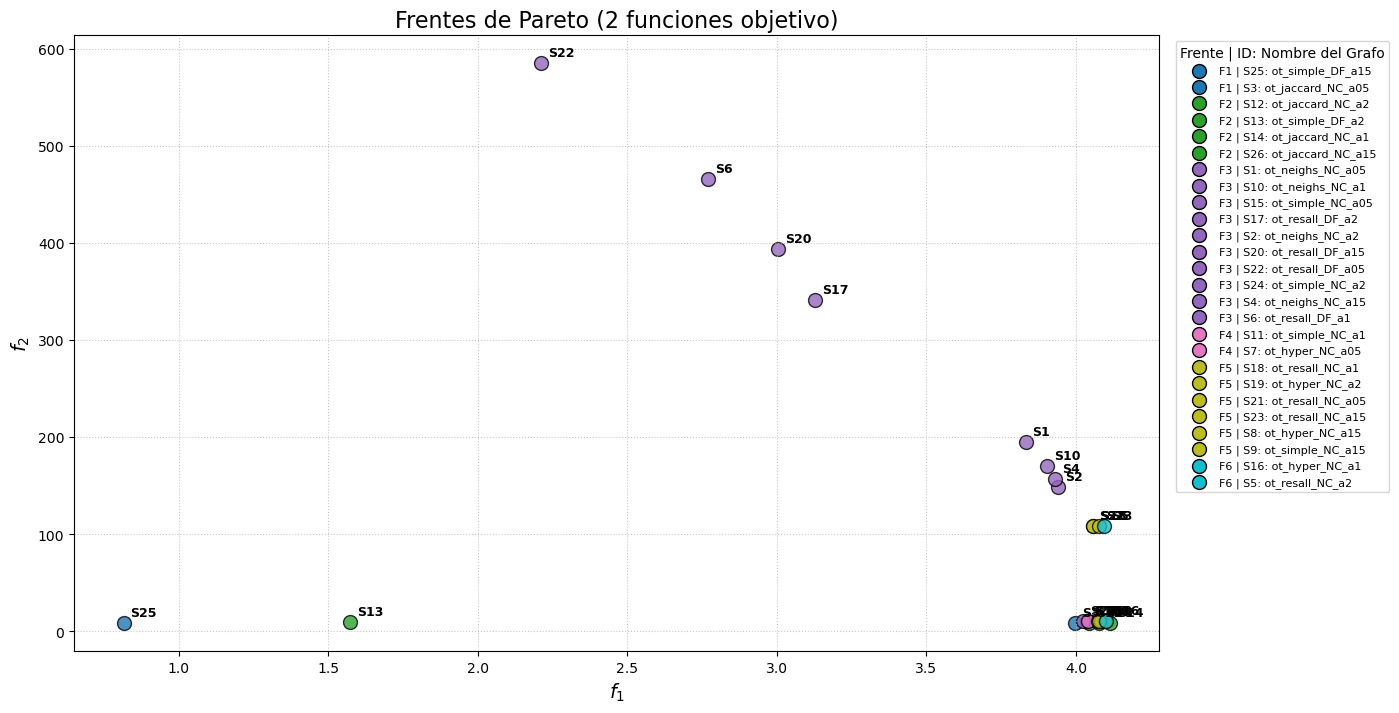

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.cm as cm

# -------------------------------------------------------------
# ASUMIMOS QUE ESTE PUNTO DEL CÓDIGO YA SE HA EJECUTADO:
# - final_DF está creado con 'f1', 'f2', 'name'.
# - solutions está lleno.
# - all_fronts está calculado.
# -------------------------------------------------------------

# --- 1. PREPARACIÓN DE DATOS Y ASIGNACIÓN DE RANKS (Reutilizamos el código robusto) ---

rank_map = {}
for rank, front in enumerate(all_fronts, 1):
    for sol in front:
        rank_map[sol["filename"]] = rank

final_DF['rank'] = final_DF['name'].map(rank_map).fillna(0).astype(int) 

plot_DF = final_DF[final_DF['rank'] > 0].copy()
plot_DF['rank_str'] = plot_DF['rank'].astype(str)
plot_DF['ID'] = 'S' + (plot_DF.reset_index().index + 1).astype(str)
plot_DF['legend_label'] = plot_DF.apply(
    lambda row: f"F{row['rank_str']} | {row['ID']}: {row['name'][4:]}", 
    axis=1
)

# --- 2. GENERAR LA GRÁFICA CON MATPLOTLIB (CORRECCIÓN DE COLOR) ---

plt.figure(figsize=(14, 8)) 

# Obtener los frentes únicos y ordenarlos
unique_ranks = sorted(plot_DF['rank'].unique())
num_unique_ranks = len(unique_ranks)

# Usamos un mapa de color más distintivo si el número de frentes es pequeño
if num_unique_ranks <= 10:
    cmap = cm.get_cmap('tab10', num_unique_ranks)
else:
    cmap = cm.get_cmap('tab20', num_unique_ranks)
    #cmap = cm.get_cmap('tab10', num_unique_ranks)

# Diccionario para almacenar handles y etiquetas de la leyenda (para evitar duplicados)
legend_data = {}

# 3a. Graficar los puntos por FRENTE (Esto garantiza el mismo color por frente)
for rank_int in unique_ranks:
    
    # 1. Filtramos el subconjunto para el frente actual
    subset = plot_DF[plot_DF['rank'] == rank_int]
    
    # 2. Obtenemos el color
    color_index = rank_int - 1
    color = cmap(color_index)
    
    # 3. Graficar: Todos los puntos de este subset tendrán el mismo color
    plt.scatter(
        subset['f1'],
        subset['f2'],
        s=100,             
        alpha=0.8,
        edgecolors='black',
        color=color # Asignación de color directo
    )
    
    # Almacenamos handles y etiquetas para la leyenda detallada
    for index, row in subset.iterrows():
        legend_data[row['ID']] = {'color': color, 'label': row['legend_label']}

# 3b. Añadir Anotaciones de Texto (ID)
for index, row in plot_DF.iterrows():
    plt.annotate(
        row['ID'],  
        (row['f1'], row['f2']),
        textcoords="offset points", 
        xytext=(5, 5),
        ha='left', 
        fontsize=9,
        weight='bold' 
    )

# 3c. Crear la Leyenda detallada (Objetos Proxy)
legend_handles = []
# Ordenamos los IDs por rank para una leyenda lógica
sorted_ids = plot_DF.sort_values(by=['rank', 'ID'])['ID'].tolist()

for id_key in sorted_ids:
    data = legend_data[id_key]
    
    proxy = plt.scatter([], [], 
                        c=[data['color']], # c acepta lista o tupla para el color
                        label=data['label'], 
                        s=100, edgecolors='black')
    legend_handles.append(proxy)


# 3d. Finalizar el Gráfico
plt.title('Frentes de Pareto (2 funciones objetivo)', fontsize=16)
plt.xlabel('$f_1$', fontsize=14)
plt.ylabel('$f_2$', fontsize=14)

# Mover el recuadro del legend más a la derecha (loc='upper left', bbox_to_anchor=(1.01, 1))
plt.legend(handles=legend_handles, 
           title="Frente | ID: Nombre del Grafo", 
           loc='upper left', 
           bbox_to_anchor=(1.01, 1), 
           fontsize=8)

plt.grid(True, linestyle=':', alpha=0.7)

plt.show()